<center>
<h1>Fake news detection using graph neural network</h1>
<h2>SAGE GNN</h2>
<i><h6>Victor GOUBET | Nicholas Tagliapietra | Asma Bakhtiariazad</h6></i>
</center>


----

# Library

In [1]:
import torch
import pickle as pk
import torch.nn.functional as F

from torch.nn import Linear, LogSoftmax
from tool_box.upfd_dataset import ext_UPFD
from tool_box.GNN_train import plot_hist, train_all_and_optimize
from torch_geometric.nn import SAGEConv, global_mean_pool, global_max_pool

# Import datasets

In [2]:
datasets = pk.load(open('../data/datasets.pkl', 'rb'))

# Define the model

In [3]:
class SAGE(torch.nn.Module):
    
    
    def __init__(self, num_n_feature, num_g_feature, emb_size, num_layers=2):
        super(SAGE, self).__init__()
        torch.manual_seed(42)
        self.emb_size = emb_size
        
        self.convs = torch.nn.ModuleList()
        for i in range(num_layers):
            size_in = num_n_feature if i == 0 else emb_size
            self.convs.append(SAGEConv(size_in, emb_size))

        # check if we have graph features to concatenate or not
        i = 2
        if num_g_feature:
             self.lin_g = Linear(num_g_feature, emb_size)
             i = 3

        self.out_layer = Linear(i * emb_size, 2)
        self.act = LogSoftmax(dim=-1)


    
    def forward(self, x, edges_idx, batch_idx, g_features):
        for i, conv in enumerate(self.convs):
            x = conv(x, edges_idx)
            if i != len(self.convs) - 1:
                x = x.relu()
                x = F.dropout(x, p=0.5, training=self.training)
            else:
                
                flatten = torch.cat([global_mean_pool(x, batch_idx),
                                     global_max_pool(x, batch_idx)], axis=1)

                if g_features.size()[-1] > 1:
                    g_ft = self.lin_g(g_features)
                    flatten = torch.cat([flatten, g_ft], axis=1)

                out = self.act(self.out_layer(flatten))
                
        return out

# Training

In [4]:
models = train_all_and_optimize(SAGE, datasets, epochs = 60)

[I 2022-01-03 16:47:49,165] A new study created in memory with name: no-name-f0128075-8d7b-452c-8572-937727e51277


--> Train on: origin


[I 2022-01-03 16:48:21,786] Trial 0 finished with value: 0.7171989889705883 and parameters: {'learning_rate': 0.001, 'weight_decay': 0.001, 'batch_size': 512, 'embedding_space_dim': 160}. Best is trial 0 with value: 0.7171989889705883.
[I 2022-01-03 16:48:38,943] Trial 1 finished with value: 0.9276194852941176 and parameters: {'learning_rate': 0.01, 'weight_decay': 0.005, 'batch_size': 512, 'embedding_space_dim': 160}. Best is trial 1 with value: 0.9276194852941176.
[I 2022-01-03 16:48:55,476] Trial 2 finished with value: 0.9168198529411764 and parameters: {'learning_rate': 0.005, 'weight_decay': 0.001, 'batch_size': 512, 'embedding_space_dim': 140}. Best is trial 1 with value: 0.9276194852941176.
[I 2022-01-03 16:49:10,036] Trial 3 finished with value: 0.9021905637254902 and parameters: {'learning_rate': 0.01, 'weight_decay': 0.005, 'batch_size': 256, 'embedding_space_dim': 120}. Best is trial 1 with value: 0.9276194852941176.
[I 2022-01-03 16:49:22,642] Trial 4 finished with value: 0

  0%|          | 0/60 [00:00<?, ?it/s]

Epochs: 10 | loss_train=0.2812488406896591  loss_val=0.3643110195795695 | acc_train=0.8778492647058824  acc_val=0.8526348039215685
Epochs: 20 | loss_train=0.22387037873268129  loss_val=0.2750033140182495 | acc_train=0.9102941176470589  acc_val=0.909466911764706
Epochs: 30 | loss_train=0.20039034485816956  loss_val=0.2212988535563151 | acc_train=0.9319852941176471  acc_val=0.9152879901960785
Epochs: 40 | loss_train=0.1478884592652321  loss_val=0.18000386158625284 | acc_train=0.9413602941176471  acc_val=0.9270067401960785
Epochs: 50 | loss_train=0.15551018714904785  loss_val=0.14070548117160797 | acc_train=0.9521139705882353  acc_val=0.9413296568627452
Epochs: 60 | loss_train=0.13058893382549286  loss_val=0.14977796375751495 | acc_train=0.9505514705882353  acc_val=0.9400275735294118


[I 2022-01-03 16:50:30,310] A new study created in memory with name: no-name-5baeb988-da62-4eee-8af4-1db7ffe0e313


--> Train on: dataset1


[I 2022-01-03 16:50:42,318] Trial 0 finished with value: 0.53515625 and parameters: {'learning_rate': 0.001, 'weight_decay': 0.01, 'batch_size': 512, 'embedding_space_dim': 80}. Best is trial 0 with value: 0.53515625.
[I 2022-01-03 16:50:55,960] Trial 1 finished with value: 0.8523092830882353 and parameters: {'learning_rate': 0.01, 'weight_decay': 0.005, 'batch_size': 512, 'embedding_space_dim': 100}. Best is trial 1 with value: 0.8523092830882353.
[I 2022-01-03 16:51:11,981] Trial 2 finished with value: 0.6797794117647059 and parameters: {'learning_rate': 0.001, 'weight_decay': 0.005, 'batch_size': 128, 'embedding_space_dim': 80}. Best is trial 1 with value: 0.8523092830882353.
[I 2022-01-03 16:51:29,130] Trial 3 finished with value: 0.8018382352941176 and parameters: {'learning_rate': 0.001, 'weight_decay': 0.01, 'batch_size': 128, 'embedding_space_dim': 120}. Best is trial 1 with value: 0.8523092830882353.
[I 2022-01-03 16:51:46,578] Trial 4 finished with value: 0.7876838235294118 a

  0%|          | 0/60 [00:00<?, ?it/s]

Epochs: 10 | loss_train=1.4505333304405212  loss_val=2.908390998840332 | acc_train=0.7672717524509803  acc_val=0.5078125
Epochs: 20 | loss_train=0.7404158512751261  loss_val=0.6586400866508484 | acc_train=0.6955805759803922  acc_val=0.7974494485294117
Epochs: 30 | loss_train=0.45267970363299054  loss_val=0.4902235120534897 | acc_train=0.8128829656862745  acc_val=0.8122127757352942
Epochs: 40 | loss_train=0.49455322821935016  loss_val=0.49866829812526703 | acc_train=0.7906326593137255  acc_val=0.7787798713235294
Epochs: 50 | loss_train=0.5128382245699564  loss_val=0.4134436249732971 | acc_train=0.8004748774509803  acc_val=0.8180147058823529
Epochs: 60 | loss_train=0.41402514775594074  loss_val=0.44509804248809814 | acc_train=0.8360523897058824  acc_val=0.8513327205882353


[I 2022-01-03 16:54:00,272] A new study created in memory with name: no-name-ef8c4de4-d2d9-48f0-af19-b57d54219e61


--> Train on: dataset2


[I 2022-01-03 16:54:15,742] Trial 0 finished with value: 0.8114889705882353 and parameters: {'learning_rate': 0.005, 'weight_decay': 0.005, 'batch_size': 128, 'embedding_space_dim': 100}. Best is trial 0 with value: 0.8114889705882353.
[I 2022-01-03 16:54:30,050] Trial 1 finished with value: 0.8160615808823529 and parameters: {'learning_rate': 0.01, 'weight_decay': 0.01, 'batch_size': 512, 'embedding_space_dim': 120}. Best is trial 1 with value: 0.8160615808823529.
[I 2022-01-03 16:54:45,350] Trial 2 finished with value: 0.7931985294117647 and parameters: {'learning_rate': 0.001, 'weight_decay': 0.01, 'batch_size': 128, 'embedding_space_dim': 100}. Best is trial 1 with value: 0.8160615808823529.
[I 2022-01-03 16:55:02,014] Trial 3 finished with value: 0.7153033088235294 and parameters: {'learning_rate': 0.005, 'weight_decay': 0.005, 'batch_size': 512, 'embedding_space_dim': 160}. Best is trial 1 with value: 0.8160615808823529.
[I 2022-01-03 16:55:17,394] Trial 4 finished with value: 0.

  0%|          | 0/60 [00:00<?, ?it/s]

Epochs: 10 | loss_train=0.4443589018450843  loss_val=0.4683039844036102 | acc_train=0.808312908496732  acc_val=0.7904411764705882
Epochs: 20 | loss_train=0.4638083941406674  loss_val=0.39330278635025023 | acc_train=0.8371629901960784  acc_val=0.8245404411764706
Epochs: 30 | loss_train=0.3959253761503432  loss_val=0.42229092717170713 | acc_train=0.8362949346405228  acc_val=0.8048713235294118
Epochs: 40 | loss_train=0.3440307594007916  loss_val=0.4368016064167023 | acc_train=0.8644301470588236  acc_val=0.8350183823529411
Epochs: 50 | loss_train=0.32524776127603316  loss_val=0.39856032729148866 | acc_train=0.8762254901960784  acc_val=0.8604779411764707
Epochs: 60 | loss_train=0.31403810282548267  loss_val=0.42325892448425295 | acc_train=0.8840890522875817  acc_val=0.8333639705882353


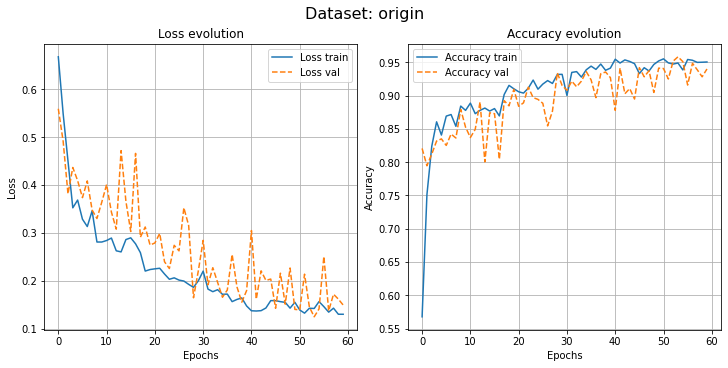

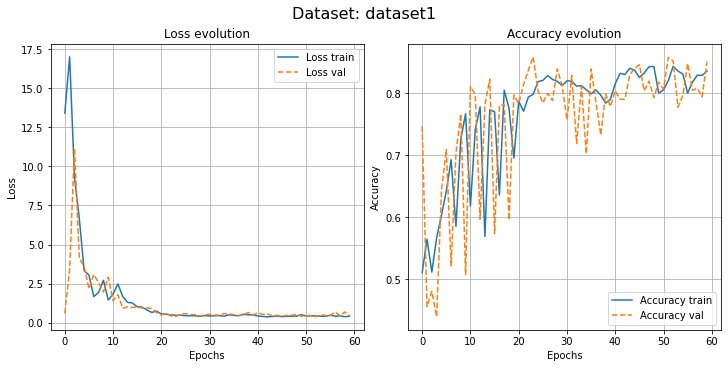

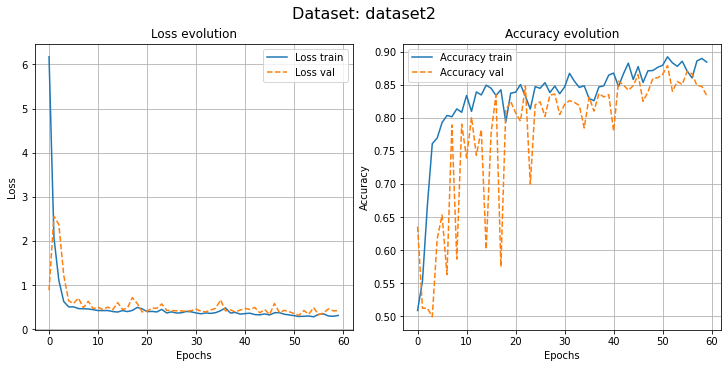

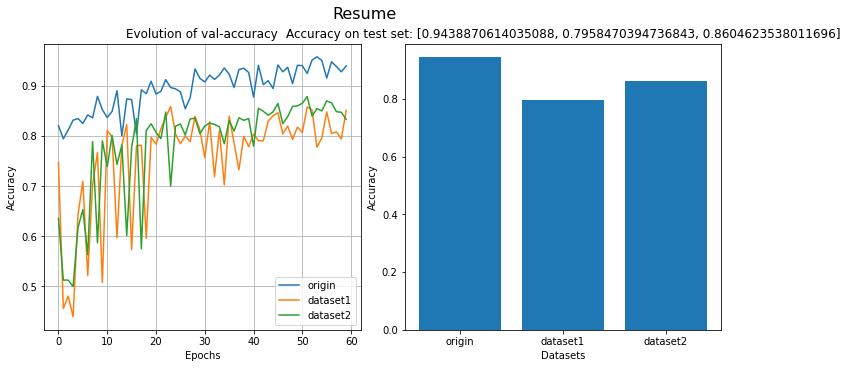

In [5]:
plot_hist(models)

# Save the three models

In [6]:
path = '../models/SAGE/'
for name, model, _, _ in models:
    torch.save(model, f'{path}SAGE_{name}')